In [4]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
#!conda install -c conda-forge geocoder --yes 
import geocoder

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')

Matplotlib version:  2.2.2
Libraries imported.


<b>1. Build the dataframe for the Toronto Neighbourhoods using BeautifulSoup.</b>

In [5]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [6]:
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
df.head(10)

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


<b>1.1 Clean up the dataframe for the Toronto neighbourhood.</b>

In [7]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


In [8]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df.loc[df['Neighbourhood']=='Not assigned', ['Neighbourhood']] = 'Queen\'s Park'
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


<b>2. Build the dataframe for Toronto neighbourhood population</b>

In [9]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
skip_table = 1

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find_all('table')[skip_table]
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [10]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)

# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese


In [11]:
# get the data size
df.shape
df1.shape

(174, 9)

In [12]:
df1['Latitude'] = ''
df1['Longitude'] = ''

# dummy values in case that geocoder is not working for the day
df1['Latitude'] = 43.638093
df1['Longitude'] = -79.4665843

<b>3. Find out the latitude and longitude for each neighbourhood.</b>

In [ ]:
# loop through the postal code to find out the latitude and longitude
for index, data in df1.iterrows():
    lat_lng_coords = None
    #print ('Now at PostalCode:', data['PostalCode'])
    #print ('Now at Neighbourhood:', data['Neighbourhood'])
    while(lat_lng_coords is None):
        #g = geocoder.google('{}, Toronto, Ontario'.format(data['PostalCode']))
        g = geocoder.google('{}, Toronto, Ontario'.format(data['Neighbourhood']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('Neighbourhood:', data['Neighbourhood'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])

<b>3.1 Print out the updated dataframe.</b>

In [13]:
# print out the updated dataframe
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,43.638093,-79.466584
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,43.638093,-79.466584
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,43.638093,-79.466584
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,43.638093,-79.466584
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian,43.638093,-79.466584
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,43.638093,-79.466584
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian,43.638093,-79.466584
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin,43.638093,-79.466584
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese,43.638093,-79.466584


<b>3.2 Double check on the data quality of the dataframe.</b>

In [14]:
# double check on the dataframe
print('The dataframe has {} neighborhoods.'.format(
        len(df1['Neighbourhood'].unique()),
        df1.shape[0]
    )
)

The dataframe has 174 neighborhoods.


<b>3.3 Add the population weightage for each neighbourhood.</b>

In [15]:
total_population = df1['Population'].sum()
#print (total_population)

# the higher populated neighbourhood will have the higher score
df1['Population Score'] = df1['Population']/total_population*100

# sort the dataframe based on the descending population score
df1 = df1.sort_values('Population Score', ascending=False)
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626
170,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928
50,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065
86,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247
98,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.638093,-79.466584,1.834774
168,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.638093,-79.466584,1.785929
44,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.638093,-79.466584,1.515581
108,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.638093,-79.466584,1.492110
139,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.638093,-79.466584,1.448645


<b>3.4 Display the top 10 populated neighbourhood in the barchart.</b>

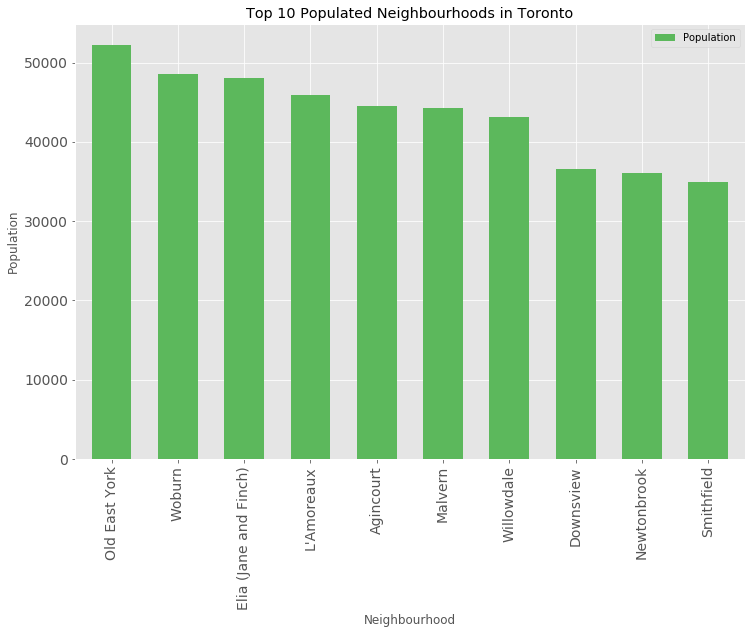

In [16]:
population_chart = df1[['Neighbourhood', 'Population']].copy()
top_chart = population_chart.head(10)
top_chart.set_index('Neighbourhood', inplace=True)

# plot data
colors = ['#5cb85c', '#5bc0de', '#d9534f']
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

<b>4. Segmenting and clustering in Toronto.</b>

In [17]:
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto Ontario are 43.638093, -79.4665843.


<b>4.1 - create the map of the Toronto Ontario and mark the neighbourhoods.</b>

In [18]:
# create map of Toronto Ontario using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  

map_to

<b>5. Adopting the Foursquare API to find out the venue category.</b>

In [19]:
# Foursquare Credentials
CLIENT_ID = 'RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB' # your Foursquare ID
CLIENT_SECRET = '2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB
CLIENT_SECRET:2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ


<b>5.1 Explore the first neighborhood in the dataframe.</b>

In [20]:
# explore the first neighborhood in our dataframe.
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626


In [21]:
neighborhood_latitude = toronto_data.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[1, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Agincourt are 43.638093, -79.4665843.


<b>5.2 Explore the top venues from Foursquare API of radius of 500M.</b>

In [22]:
# explore the top 100 venues
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB&client_secret=2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ&v=20180605&ll=43.638093,-79.4665843&radius=500&limit=100'

In [23]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ba8ea016a60710aa52231ac'},
 'response': {'headerLocation': 'Swansea',
  'headerFullLocation': 'Swansea, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 13,
  'suggestedBounds': {'ne': {'lat': 43.6425930045, 'lng': -79.46037797072417},
   'sw': {'lat': 43.633592995499995, 'lng': -79.47279062927582}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c6208cbfa7bc92895620d27',
       'name': 'Waterfront Trail',
       'location': {'lat': 43.63585927859915,
        'lng': -79.46752926947985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.63585927859915,
          'lng': -79.46752926947985}],
        'distance': 260,
        'cc': 'CA',
        'city': 'Toronto',
        'state': 'ON',
      

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Waterfront Trail,Trail,43.635859,-79.467529
1,Windermere By The Lake,Building,43.636862,-79.468536
2,Sunnyside Park,Park,43.636670,-79.461212
3,Sir Casimir Gzowski Park,Park,43.635649,-79.465486
4,TTC Stop #14281,Bus Stop,43.637932,-79.465802


In [26]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

13 venues were returned by Foursquare.


In [27]:
# Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<b>5.3 Get nearby venues for Toronto neighbourhoods.</b>

In [28]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

Old East York
Woburn
Elia (Jane and Finch)
L'Amoreaux
Agincourt
Malvern
Willowdale
Downsview
Newtonbrook
Smithfield
Fairbank
Riverdale
Don Valley Village
Bendale
Parkdale
Humewood–Cedarvale
Tam O'Shanter – Sullivan
Parkwoods
Milliken
York University Heights
Richview
Scarborough Junction
West Hill
Steeles
Forest Hill
Davisville
Leslieville
High Park North
Rouge
Eglinton East
East Danforth
Don Mills
Flemingdon Park
Mount Dennis
The Beaches
Maple Leaf
Upper Beaches
Eatonville
Glen Park
Hillcrest
Thorncliffe Park
Wexford
Silverthorn
O'Connor–Parkview
Sunnylea
York Mills
Amesbury
Earlscourt
Victoria Village
Thistletown
Pleasant View
Islington – Six Points
Weston
Scarborough City Centre
Westminster
Kingsview Village
Roncesvalles
The Annex
Deer Park
Bathurst Manor
Humbermede
St. James Town
Cliffcrest
Humber Valley Village
Harbourfront / CityPlace
Mimico
Dorset Park
Leaside
Lawrence Manor
Bedford Park
Wilson Heights
Church and Wellesley
Oakridge
Bayview Woods – Steeles
Ionview
Highland Creek
G

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old East York,43.638093,-79.466584,Waterfront Trail,43.635859,-79.467529,Trail
1,Old East York,43.638093,-79.466584,Windermere By The Lake,43.636862,-79.468536,Building
2,Old East York,43.638093,-79.466584,Sunnyside Park,43.636670,-79.461212,Park
3,Old East York,43.638093,-79.466584,Sir Casimir Gzowski Park,43.635649,-79.465486,Park
4,Old East York,43.638093,-79.466584,TTC Stop #14281,43.637932,-79.465802,Bus Stop
5,Old East York,43.638093,-79.466584,Sunnyside Bike Park,43.636451,-79.465013,Park
6,Old East York,43.638093,-79.466584,TTC Stop #14282,43.637226,-79.469376,Light Rail Station
7,Old East York,43.638093,-79.466584,TTC Stop #14395,43.637279,-79.469424,Light Rail Station
8,Old East York,43.638093,-79.466584,Royal Burger,43.635264,-79.466304,American Restaurant
9,Old East York,43.638093,-79.466584,NXT Condo Gym,43.636120,-79.470463,Gym / Fitness Center


<b>5.4 Find out how many unique categories in the result.</b>

In [29]:
# find out how many unique categories
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,13,13,13,13,13,13
Alderwood,13,13,13,13,13,13
Alexandra Park,13,13,13,13,13,13
Allenby,13,13,13,13,13,13
Amesbury,13,13,13,13,13,13
Armour Heights,13,13,13,13,13,13
Banbury,13,13,13,13,13,13
Bathurst Manor,13,13,13,13,13,13
Bay Street Corridor,13,13,13,13,13,13


In [30]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 8 uniques categories.


<b>5.5 Analyzing each neighborhood now in Toronto.</b>

In [31]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,American Restaurant,Building,Bus Stop,Gym / Fitness Center,Lake,Light Rail Station,Park,Trail
0,Old East York,0,0,0,0,0,0,0,1
1,Old East York,0,1,0,0,0,0,0,0
2,Old East York,0,0,0,0,0,0,1,0
3,Old East York,0,0,0,0,0,0,1,0
4,Old East York,0,0,1,0,0,0,0,0


In [32]:
toronto_onehot.shape

(2262, 9)

<b>5.6 Group the rows together based on the mean of the frequency of occurrence of each category.</b>

In [33]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,American Restaurant,Building,Bus Stop,Gym / Fitness Center,Lake,Light Rail Station,Park,Trail
0,Agincourt,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
1,Alderwood,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
2,Alexandra Park,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
3,Allenby,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
4,Amesbury,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
5,Armour Heights,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
6,Banbury,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
7,Bathurst Manor,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
8,Bay Street Corridor,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
9,Bayview Village,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923


In [34]:
toronto_grouped.shape

(174, 9)

<b>5.7 Find out the top 10 most common venues in the neighbourhood.</b>

In [35]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0                  Park  0.31
1  Gym / Fitness Center  0.15
2    Light Rail Station  0.15
3   American Restaurant  0.08
4              Building  0.08


----Alderwood----
                  venue  freq
0                  Park  0.31
1  Gym / Fitness Center  0.15
2    Light Rail Station  0.15
3   American Restaurant  0.08
4              Building  0.08


----Alexandra Park----
                  venue  freq
0                  Park  0.31
1  Gym / Fitness Center  0.15
2    Light Rail Station  0.15
3   American Restaurant  0.08
4              Building  0.08


----Allenby----
                  venue  freq
0                  Park  0.31
1  Gym / Fitness Center  0.15
2    Light Rail Station  0.15
3   American Restaurant  0.08
4              Building  0.08


----Amesbury----
                  venue  freq
0                  Park  0.31
1  Gym / Fitness Center  0.15
2    Light Rail Station  0.15
3   American Restaurant  0.08
4              Building  0.08


In [36]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
toronto_grouped.shape[0]
toronto_grouped.head()

,Neighbourhood,American Restaurant,Building,Bus Stop,Gym / Fitness Center,Lake,Light Rail Station,Park,Trail
0,Agincourt,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
1,Alderwood,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
2,Alexandra Park,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
3,Allenby,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923
4,Amesbury,0.076923,0.076923,0.076923,0.153846,0.076923,0.153846,0.307692,0.076923


<b>5.8 Explore the top 8 venues for each neighborhood.</b>

In [38]:
# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
1,Alderwood,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
2,Alexandra Park,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
3,Allenby,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
4,Amesbury,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
5,Armour Heights,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
6,Banbury,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
7,Bathurst Manor,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
8,Bay Street Corridor,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
9,Bayview Village,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


<b>5.9 Add the venue weighted score for each neighbourhood.</b>

In [39]:
neighborhoods_venues_sorted['Venue Score'] = 0
venue = 'Park'
venue_count = 0

# award the score based on the common findings
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(venue), ['Venue Score']] = 1.0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.9
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.8
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['4th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.7
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['5th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.6
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['6th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.5
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['7th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.4
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['8th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.3

# merge the two dataframes
merged_data = pd.merge(df1, neighborhoods_venues_sorted, on='Neighbourhood')

# clean up the merged dataset
merged_data = merged_data.drop('1st Most Common Venue', 1)
merged_data = merged_data.drop('2nd Most Common Venue', 1)
merged_data = merged_data.drop('3rd Most Common Venue', 1)
merged_data = merged_data.drop('4th Most Common Venue', 1)
merged_data = merged_data.drop('5th Most Common Venue', 1)
merged_data = merged_data.drop('6th Most Common Venue', 1)
merged_data = merged_data.drop('7th Most Common Venue', 1)
merged_data = merged_data.drop('8th Most Common Venue', 1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)

merged_data.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626,1.0
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928,1.0
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065,1.0
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439,1.0
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247,1.0
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.638093,-79.466584,1.834774,1.0
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.638093,-79.466584,1.785929,1.0
7,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.638093,-79.466584,1.515581,1.0
8,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.638093,-79.466584,1.492110,1.0
9,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.638093,-79.466584,1.448645,1.0


<b>5.10 Calculate the total weighted score for each neighbourhood.</b>

In [41]:
# considering this to be a fair weightage on both parameters
population_weight = 0.5
venue_weight = 0.5

# calculate the total score
merged_data['Total Score'] = (merged_data['Population Score']*population_weight) + (merged_data['Venue Score']*venue_weight)

# sort the dataframe based on the descending total score
merged_data = merged_data.sort_values('Total Score', ascending=False)

<b>6. Cluster the neighbourhoods using K-Clustering.</b>

In [56]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = merged_data.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Income', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Density', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language %', 1)

toronto_grouped_clustering.head(10)

,Population,Land Area,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score
0,52220,7.94,-4.6,22.0,43.638093,-79.466584,2.161626,1.0,1.580813
1,48507,13.34,-1.5,13.3,43.638093,-79.466584,2.007928,1.0,1.503964
2,48003,7.66,-10.0,13.0,43.638093,-79.466584,1.987065,1.0,1.493533
3,45862,7.15,0.9,13.4,43.638093,-79.466584,1.898439,1.0,1.449220
4,44577,12.45,4.6,11.1,43.638093,-79.466584,1.845247,1.0,1.422624
5,44324,8.86,1.5,13.6,43.638093,-79.466584,1.834774,1.0,1.417387
6,43144,7.68,62.3,15.6,43.638093,-79.466584,1.785929,1.0,1.392964
7,36613,16.13,-5.0,14.4,43.638093,-79.466584,1.515581,1.0,1.257790
8,36046,8.77,0.3,16.6,43.638093,-79.466584,1.492110,1.0,1.246055
9,34996,6.45,-7.2,12.8,43.638093,-79.466584,1.448645,1.0,1.224323


In [57]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 1, 1, 1], dtype=int32)

<b>6.1 Clean up the data for clustering.</b>

In [58]:
# empty the invalid data
#merged_data['Neighbourhood'] = neighborhoods_venues_sorted['Neighbourhood']
#print(toronto_data.shape)
merged_data.isnull().sum()
merged_data.dropna(how = 'any', axis = 0, inplace = True)
print(merged_data.shape)
print(neighborhoods_venues_sorted.shape)

(174, 14)
(174, 10)


In [62]:
merged_data.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626,1.0,1.580813,3
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928,1.0,1.503964,3
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065,1.0,1.493533,3
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439,1.0,1.449220,3
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247,1.0,1.422624,3


In [64]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
1,Alderwood,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
2,Alexandra Park,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
3,Allenby,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
4,Amesbury,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


In [65]:
toronto_merged = toronto_data

# add clustering labels
merged_data['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = merged_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626,1.0,1.580813,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928,1.0,1.503964,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065,1.0,1.493533,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439,1.0,1.449220,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247,1.0,1.422624,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


<b>6.2 Draw the cluster map.</b>

In [69]:
#import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b>7. Evaluate the final result.</b>

In [70]:
# display the top 5 neighbourhoods
target = merged_data.head(5)
target.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626,1.0,1.580813,3
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928,1.0,1.503964,3
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065,1.0,1.493533,3
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439,1.0,1.449220,3
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247,1.0,1.422624,3


In [74]:
# Cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,52220,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626,1.0,1.580813,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
1,48507,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928,1.0,1.503964,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
2,48003,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065,1.0,1.493533,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
3,45862,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439,1.0,1.449220,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
4,44577,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247,1.0,1.422624,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
5,44324,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.638093,-79.466584,1.834774,1.0,1.417387,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
6,43144,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.638093,-79.466584,1.785929,1.0,1.392964,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


In [75]:
# Cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
7,36613,"26,751",14.4,Italian (11.7%),11.7% Italian,43.638093,-79.466584,1.515581,1.0,1.257790,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
8,36046,"33,428",16.6,Russian (8.8%),08.8% Russian,43.638093,-79.466584,1.492110,1.0,1.246055,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
9,34996,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.638093,-79.466584,1.448645,1.0,1.224323,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
10,34121,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.638093,-79.466584,1.412425,1.0,1.206213,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
11,31007,"40,139",20.0,Cantonese (6.7%),06.7% Cantonese,43.638093,-79.466584,1.283522,1.0,1.141761,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
12,29740,"30,442",17.1,Unspecified Chinese (9.7%),09.7% Unspecified Chinese,43.638093,-79.466584,1.231075,1.0,1.115538,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
13,28945,"29,723",13.0,Tamil (3.7%),03.7% Tamil,43.638093,-79.466584,1.198167,1.0,1.099083,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
14,28367,"26,314",22.2,Polish (2.9%),02.9% Polish,43.638093,-79.466584,1.174241,1.0,1.087120,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
15,27515,"40,404",24.2,Spanish (3.6%),03.6% Spanish,43.638093,-79.466584,1.138972,1.0,1.069486,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
16,27235,"27,717",12.2,Unspecified Chinese (12.6%),12.6% Unspecified Chinese,43.638093,-79.466584,1.127382,1.0,1.063691,1,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


In [76]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
120,7672,"213,941",11.3,Unspecified Chinese (1.0%),01.0% Unspecified Chinese,43.638093,-79.466584,0.317579,1.0,0.658790,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
121,7319,"29,576",7.9,Punjabi (26.7%),26.7% Punjabi,43.638093,-79.466584,0.302967,1.0,0.651484,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
122,7262,"41,998",12.7,Unspecified Chinese (6.5%),06.5% Unspecified Chinese,43.638093,-79.466584,0.300608,1.0,0.650304,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
123,6666,"28,067",20.0,Portuguese (13.0%),13.0% Portuguese,43.638093,-79.466584,0.275936,1.0,0.637968,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
124,6653,"214,110",8.3,French (0.8%),00.8% French,43.638093,-79.466584,0.275398,1.0,0.637699,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
125,6641,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,43.638093,-79.466584,0.274902,1.0,0.637451,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
126,6544,"23,301",19.0,Portuguese (17.0%),17.0% Portuguese,43.638093,-79.466584,0.270886,1.0,0.635443,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
127,6524,"44,611",21.2,Portuguese (4.0%),04.0% Portuguese,43.638093,-79.466584,0.270058,1.0,0.635029,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
128,6494,"127,356",15.1,Serbian (0.9%),00.9% Serbian,43.638093,-79.466584,0.268817,1.0,0.634408,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
129,6378,"40,617",19.5,French (2.5%),02.5% French,43.638093,-79.466584,0.264015,1.0,0.632007,2,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


In [77]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,52220,"33,172",22.0,Greek (4.3%),04.3% Greek,43.638093,-79.466584,2.161626,1.0,1.580813,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
1,48507,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.638093,-79.466584,2.007928,1.0,1.503964,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
2,48003,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.638093,-79.466584,1.987065,1.0,1.493533,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
3,45862,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.638093,-79.466584,1.898439,1.0,1.449220,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
4,44577,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.638093,-79.466584,1.845247,1.0,1.422624,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
5,44324,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.638093,-79.466584,1.834774,1.0,1.417387,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
6,43144,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.638093,-79.466584,1.785929,1.0,1.392964,3,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


In [78]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
63,14453,"80,618",12.0,Ukrainian (3.9%),03.9% Ukrainian,43.638093,-79.466584,0.598276,1.0,0.799138,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
64,14368,"69,232",16.0,Unspecified Chinese (2.4%),02.4% Unspecified Chinese,43.638093,-79.466584,0.594758,1.0,0.797379,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
65,14198,"47,011",11.6,Polish (3.6%),03.6% Polish,43.638093,-79.466584,0.587721,1.0,0.793860,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
66,14189,"26,525",15.2,Tamil (9.5%),09.5% Tamil,43.638093,-79.466584,0.587348,1.0,0.793674,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
67,13876,"82,670",9.7,Bulgarian (0.4%),00.4% Bulgarian,43.638093,-79.466584,0.574391,1.0,0.787196,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
68,13750,"36,361",15.9,Filipino (7.2%),07.2% Filipino,43.638093,-79.466584,0.569176,1.0,0.784588,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
69,13749,"80,827",15.2,Greek (0.7%),00.7% Greek,43.638093,-79.466584,0.569134,1.0,0.784567,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
70,13732,"37,978",15.9,Filipino (6.2%),06.2% Filipino,43.638093,-79.466584,0.568431,1.0,0.784215,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
71,13397,"37,653",25.1,Spanish (1.8%),01.8% Spanish,43.638093,-79.466584,0.554563,1.0,0.777282,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant
72,13368,"21,155",20.8,Bengali (12.6%),12.6% Bengali,43.638093,-79.466584,0.553363,1.0,0.776682,4,Park,Light Rail Station,Gym / Fitness Center,Trail,Lake,Bus Stop,Building,American Restaurant


<b>8. Final Analysis</b>

Above marked my completion to explore and cluster the neighborhoods in the borough of Scarborough in Toronto Ontario. After examining all the 5 resultant clusters, the features that make each cluster different can be grouped. It has been concluded that each cluster posses a certain type of venues that make them different from the others in the way they can therefore can group together. By looking at each cluster's characteristics, I have the following findings:

1. Cluster 1: The Recreational cluster. It has a lot of restaurants and some other venues like stadium as the common venue in this cluster across the 1st most common and also the 2nd most common.

2. Cluster 2: The cafe cluster. Here the most common places to find are cafes, coffee shops, and bars.

3. Cluster 3: The zen cluster. All the venues in this cluster are parks and yoga studios. It looks like the place where people go to perform relax and leisure activities.

4. Cluster 4: The commercial cluster. All that can be found here are banks, donut shops, and dog runs places among others. This cluster has also stores and restaurans. These places must have an important commercial affluence, due to the shops proximity to the banks. Money is retrieved and spent in the same place.

5. Cluster 5: The home services cluster. The most common venues to find in this cluster are home services companies. Specialized in helping elderly people in their homes. There are also a lot of baseball fields and yoga studio. People may come to these neighborhoods to practice sports.
